## Ranking of estimation methods for a given dataset 

We illustrate the comparison of various estimation methods for a given datasets by ranking them according to their performance against refutation tests accounting for both the observed unmodelled confounding error and unobserved confounding error. 

In [1]:
# Importing all the required libraries
import sys
import argparse
import xgboost
import numpy as np
import pandas as pd
import os
import pdb
import random
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import mean_absolute_error
from dowhy import CausalModel
from datetime import datetime
from collections import namedtuple

import statsmodels.api as sm
from sklearn import linear_model

import dowhy
from dowhy.utils import dgp
from dowhy.utils.dgps.linear_dgp import LinearDataGeneratingProcess
from dowhy import CausalModel
from datetime import datetime
from collections import namedtuple
from dowhy.causal_refuters.add_unobserved_common_cause import AddUnobservedCommonCause

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


/home/amshar/python-environments/vpy38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def convert_singleton_to_float(arr):
    '''Helper function.'''
    array = []

    if len(arr) == 1 and type(arr[0]) != np.ndarray:
        return arr[0]

    for element in arr:
        while type(element) == np.ndarray or isinstance(element, list) :
            if len(element) > 1:
                raise ValueError("This script only accepts one value for the refute")
            element = element[0]
        array.append(element)

    return array

In [3]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

RESULTSFOLDER = "results/"
ensure_dir(RESULTSFOLDER)
# Create the estimator named tuple to wrap the name and properties
Estimator = namedtuple('Estimator', ['name','params'])
Refuter = namedtuple('Refuter', ['name','params'])

class Experiment():
    '''
    Class to define the experiment setup to compare a list of estimators across a list of refuters for the given dataset. 
    '''
    def __init__(self, **kwargs):
        self.experiment_name = kwargs['experiment_name']
        self.experiment_id = kwargs['experiment_id']
        self.num_experiments = kwargs['num_experiments']
        self.sample_sizes = kwargs['sample_sizes']
        self.dgps = kwargs['dgps']
        self.estimators = kwargs['estimators']
        self.refuters = kwargs['refuters']
        self.results = []
        self.simulate_unobserved_confounding = kwargs["simulate_unobserved_confounding"]

        # Handle input errors in sample_sizes
        if isinstance(self.sample_sizes, list) == False:
            if type(self.sample_sizes) != int:
                raise ValueError('The input to "sample_sizes" should be an int or a list')
            else:
                self.sample_sizes = [self.sample_sizes]

        # Handle input errors in DGPs
        if isinstance(self.dgps, list) == False:
            if isinstance(self.dgps, DataGeneratingProcess) == False:
                raise ValueError('The input to "dgps" should be a list or a subclass of "DataGeneratingProcess"')
            else:
                self.dgps = [self.dgps]

        # Handle inputs errors in estimators
        if isinstance(self.estimators, list) == False:
            if isinstance(self.estimators, Estimator) == False:
                raise ValueError('The input to "estimators" should be a list or an Estimator namedtuple')
            else:
                self.estimators = [self.estimators]

        # Handle input errors in refuters
        if isinstance(self.refuters, list) == False:
            if isinstance(self.refuters, Refuter) == False:
                raise ValueError('The input to "refuters" should be a list of a Refuter namedtuple')
            else:
                self.refuters = [self.refuters]

    def experiment(self):
        print("\n\nRunning Experiment:",self.experiment_name + '_' + str(self.experiment_id) )

        for exp in range(self.num_experiments):
            print("\n\nRunning Experiment Number:",exp)

            for sample_size in self.sample_sizes:

                print("\n\nCurrent Sample Size:",sample_size)

                for dgp in self.dgps:
                    print("\n\nThe current DGP:")
                    print(dgp)
                    estimates = []
                    estimate_values = []
                    estimated_effect = []
                    new_effect = []
                    p_value = []
                    data = dgp.generate_data(sample_size)
                    print("printing data shape")
                    print(data.values.shape)
                    print(dgp.true_value)
                    print("check")
                    if dgp.treatment_is_binary:
                        data[dgp.treatment] = data[dgp.treatment].astype(bool)
                    #k = len(dgp.confounder)-4
                    #confounder_list = random.sample(dgp.confounder, k)
                    confounder_list = ['w2','w3']

                    
                    s = set(confounder_list)
                    unobserved_confounders = [x for x in dgp.confounder if x not in s]
                    df_unobserved_confounders = pd.DataFrame(data = data[[c for c in data.columns if c in unobserved_confounders]])

                    df_unobserved_confounders.to_csv("results/unobserved_confounders.csv")
                    print("printing length of confounder list:", len(confounder_list))
                    print("printing confounder list:", confounder_list)

                    

                    print("data columns")
                    
                    print("data columns", data.columns)
                    model = CausalModel(
                        data = data,
                        treatment = dgp.treatment,
                        outcome = dgp.outcome,
                        common_causes = confounder_list,
                        effect_modifiers = dgp.effect_modifier
                    )
                    model.view_model()
                    from IPython.display import Image, display
                    display(Image(filename="causal_model.png"))

                    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
                    
                    print("identified_estimand:", identified_estimand)
                    #print("identified_estimand:", identified_estimand)
                    print("\n\nRunning the estimators:\n")
                    for estimator in self.estimators:
                        print("The current estimator:", estimator)
                        print("estimator.params", estimator.params)
                        estimate = model.estimate_effect(
                            identified_estimand,
                            method_name = estimator.name,
                            method_params = estimator.params
                        )
                        print("printing estimate's type")
                        print(type(estimate))
                        estimates.append(estimate)
                        estimate_values.append(estimate.value)
                    estimate_values = convert_singleton_to_float(estimate_values)
                    print("estimate_values", estimate_values)
                    print("\n\nRunning the refuters:\n")
                    for refuter in self.refuters:
                        print("The current refuter:", refuter)
                        
                        for estimate in estimates:
                            if self.simulate_unobserved_confounding == True:
                                print("********%%%%%%%%%$$$$$&&^**^^^^*^*^*")
                                if refuter.name == 'dummy_outcome_refuter':
                                    add_unobserved_confounder = AddUnobservedCommonCause(data, identified_estimand, estimate)
                                    print("add_unobserved_confounder", add_unobserved_confounder)
                                    unobserved_confounder_values = add_unobserved_confounder.include_simulated_confounder(convergence_threshold = 0.11, c_star_max = 1500)
                                    refuter.params['unobserved_confounder_values'] = unobserved_confounder_values
                                    print('refuter.params', refuter.params)
                            refute = model.refute_estimate(
                                identified_estimand,
                                estimate,
                                method_name = refuter.name,
                                **refuter.params,
    
                                

                            )
                            print("printing refute's type")
                            print(type(refute))
                            if(refuter.name == 'dummy_outcome_refuter'):
                                refute = refute[0]
                            if refute.refutation_result is not None:
                                p_value.append(refute.refutation_result['p_value'])
                            else:
                                p_value.append(None) 

                            estimated_effect.append(refute.estimated_effect)
                            #print("refute.estimate_effect()", refute.estimate_effect())
                            new_effect.append(refute.new_effect)

                    estimated_effect = convert_singleton_to_float(estimated_effect)
                    new_effect = convert_singleton_to_float(new_effect)
                    p_value = convert_singleton_to_float(p_value)
                    true_value = convert_singleton_to_float(dgp.true_value)
                    
                    print("estimated effect", estimated_effect)
                    print("new_effect", new_effect)
                    print("p_value", p_value)
                    print("true value", true_value)
                    self.results.append([exp, sample_size, dgp.NAME, *estimate_values, *estimated_effect, *new_effect, *p_value, true_value])


        print("\n\nCompleted all experiments. Saving the data...")

        COLUMNS = ['EXPERIMENT', 'SAMPLE_SIZE', 'DGP']
        RESULT_CATEGORIES = ['ESTIMATED_EFFECT', 'NEW_EFFECT', 'P_VALUE']
        estimator_names = [estimator.name for estimator in self.estimators]
        refuter_names = [refuter.name for refuter in self.refuters]

        for estimator_name in estimator_names:
            COLUMNS += ['ORIGINAL_ESTIMATE'+ ':' + estimator_name]

        for result_category in RESULT_CATEGORIES:
            for refuter_name in refuter_names:
                for estimator_name in estimator_names:
                    COLUMNS += [refuter_name + ':' + estimator_name + ':' + result_category]

        COLUMNS += ['TRUE_VALUE']

        csv_file = RESULTSFOLDER + self.experiment_name+ '_' + str(self.experiment_id) + '_' + str(datetime.utcnow().date()) + '_data.csv'
        onlyres_csv_file = RESULTSFOLDER + "onlyres_"+ self.experiment_name+ '_' + str(self.experiment_id) + '_' + str(datetime.utcnow()) + '_data.csv'
        self.results = pd.DataFrame(data=self.results,columns=COLUMNS)
        self.results.to_csv(csv_file.replace(" ", ""), index=False)

        print("Data has been saved in ",csv_file)

        return csv_file

In [4]:
#Defining the Data Generating Process 
ldgp = LinearDataGeneratingProcess(treatment=['t1'], outcome=['y'], confounder=['w1','w2', 'w3','w4','w5','w6'], effect_modifier=['x1','x2'], seed=None, treatment_is_binary=True)

#Defining the sample size 
sample_size = 1000

dgp_dict = {'ldgp':ldgp}
dgp_list = []
dgp_list.append( dgp_dict['ldgp'] )


# Create a namedtuple to store the name of the estimator and the parameters passed
estimator_list = ["backdoor.linear_regression",
                  #"backdoor.propensity_score_stratification",
                  "backdoor.propensity_score_matching",
                  "backdoor.propensity_score_weighting",
                  "backdoor.econml.dml.DML",
                  "backdoor.econml.dr.LinearDRLearner",
                  #"backdoor.econml.metalearners.TLearner",
                  #"backdoor.econml.metalearners.XLearner",
                  #"backdoor.causalml.inference.meta.LRSRegressor",
                  #"backdoor.causalml.inference.meta.XGBTRegressor",
                  #"backdoor.causalml.inference.meta.MLPTRegressor",
                  #"backdoor.causalml.inference.meta.BaseXRegressor"
                ]
method_params= [    None,
                    #None,
                    { "init_params":{} },
                    { "init_params":{} },
                    {"init_params":{'model_y':GradientBoostingRegressor(),
                                    'model_t': GradientBoostingRegressor(),
                                    "model_final":LassoCV(fit_intercept=False),
                                    'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                     "fit_params":{}},
                    {"init_params":{ 'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto'),
                        },
                    "fit_params":{}
                    },
                    '''{"init_params": {'models': GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(sample_size/100))
                                    },
                    "fit_params":{}
                    },
                    {"init_params":{'models': GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(sample_size/100)),
                        'propensity_model': RandomForestClassifier(n_estimators=100, max_depth=6,
                                                                              min_samples_leaf=int(sample_size/100))
                        },
                     "fit_params":{}
                    },
                    {"init_params":{},},
                    {"init_params":{
                        'learner':XGBRegressor()
                        }
                    }'''
                ]
estimator_tuples = []
refuter_tuples = []

refuter_list = ['dummy_outcome_refuter']
refuter_params = [{'num_simulations':5,'transformation_list': [('random_forest',{'n_estimators':100, 'max_depth':6})], 'true_causal_effect':(lambda x:0.5)}]


# Iterate through the names and parameters to create a list of namedtuples
for name, param in zip(estimator_list,method_params):
    estimator_tuples.append(Estimator._make([name, param]))
    
for name, param in zip(refuter_list, refuter_params):
    refuter_tuples.append(Refuter._make([name, param]))


In [5]:
def plot_MAEs(res):
    true_value_column = res.columns[-1]
    estimate_columns=res.columns[3:-1]
    #print(estimate_columns)
    #print(type(estimate_columns))
    estimate_columns.append(pd.Index(res["TRUE_VALUE"]))
    #print(estimate_columns)
    fig, ax = plt.subplots()
    MAE ={}
    for colname in estimate_columns:
        if colname not in ('ORIGINAL_ESTIMATE:backdoor.propensity_score_weighting',):
                           #'ORIGINAL_ESTIMATE:backdoor.econml.metalearners.TLearner'):
            plt.plot(res[colname], res["TRUE_VALUE"], marker='o', linestyle="None", label=colname)
            "Mean Absolute Error (MAE): {}".format(mean_absolute_error(res[colname], res["TRUE_VALUE"]))
            MAE[colname] = mean_absolute_error(res[colname], res["TRUE_VALUE"])
    fig.suptitle('Calibration plot showing the accuracy of different causal estimators [P(T=1)=0.9]')
    ax.set_xlabel('Estimated effect')
    ax.set_ylabel('True causal effect')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),
              fancybox=True, shadow=True, ncol=2)
    plt.show()
    print("Printing MAE of various estimates: ")
    MAE_values = {k: v for k, v in sorted(MAE.items(), key=lambda item: item[1], reverse = True)}
    for k,v in MAE_values.items():
        print(k, v)

In [6]:
def plot_estimators_and_refuters(refuter, estimator):   
    x = list(res['EXPERIMENT'])
    y1 = list(res[refuter+':'+estimator+':ESTIMATED_EFFECT'])
    y2 = list(res[refuter+':'+estimator+':NEW_EFFECT'])
    #print(res['TRUE_VALUE'])
    y3 = list(res['TRUE_VALUE'])
    y4 = list(res[refuter+':'+estimator+':P_VALUE'])
    plt.scatter(x, y1, c ="blue", label = "Estimated Effect") 
    plt.scatter(x, y2, c ="red", label = "New Effect")
    plt.scatter(x, y3, c ="green", label = "True Value")
    plt.scatter(x, y4, c ="yellow", label = "P Value")
    plt.xlabel("EXPERIMENT") 
    plt.ylabel("EFFECT")
    legend = plt.legend(loc=4, fontsize='small', fancybox=True)
    plt.title(estimator) 
    plt.show()
    plt.savefig(estimator+'.png')

In [7]:
def plot_deviations(estimator_list, deviation_list):
    plt.scatter(estimator_list, deviation_list)
    plt.xticks(estimator_list, estimator_list, rotation='vertical')
    plt.show()

## Observed unmodelled confounding error

For each estimator, we use dummy outcome refuter to check the observed unmodelled confounding error for each estimator. That is, we run the refutation test for each estimator only on the observed confounders and analyse what amount of confounding error is present unmodelled amongst the observed variables.



Running Experiment: Test_1


Running Experiment Number: 0


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {}
        bias: {}
        seed: None
        treatment_is_binary: True
        percentile: 0.9
        
printing data shape
(1000, 10)
[0.26451385]
check
printing length of confounder list: 2
printing confounder list: ['w2', 'w3']
data columns
data columns Index(['x1', 'x2', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 't1', 'y'], dtype='object')


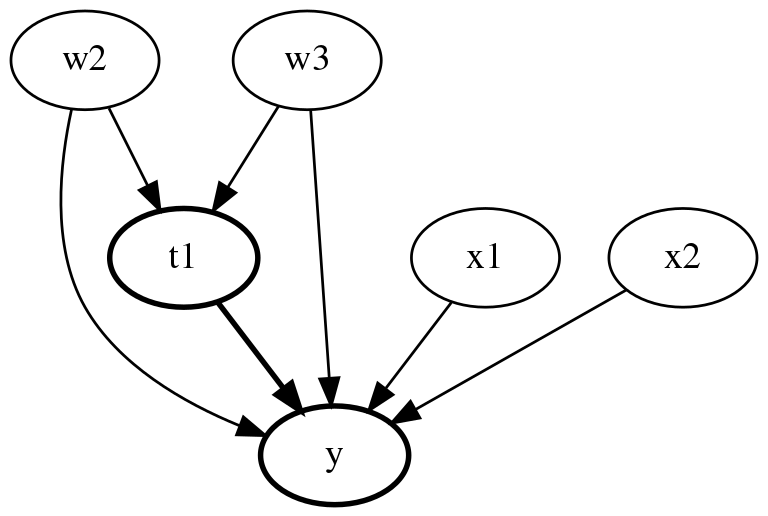

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w2,w3))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w2,w3,U) = P(y|t1,w2,w3)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


/home/amshar/python-environments/vpy38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


ValueError: zero-size array to reduction operation maximum which has no identity

In [8]:
# Define the properties of the experiment
# The name of the experiment
# The experiment ID
# The number of experiments to be run with the SAME parameters
# The size of the samples to be run
# The list of DGPs to be run
# The list of estimators
observed_confounding_error = Experiment(
    experiment_name='Test',
    experiment_id='1',
    num_experiments=10, # 10
    sample_sizes=sample_size,
    dgps=dgp_list,
    estimators=estimator_tuples,
    refuters=refuter_tuples,
    simulate_unobserved_confounding = False 
)

# Run the experiment
res = pd.read_csv(observed_confounding_error.experiment())

In [9]:
#PLOT
#This plot shows the Mean Absolute Error of the Orginal Estimate from the true value and of the New Effect from 
#the expected value for each estimator. 
plot_MAEs(res)

NameError: name 'res' is not defined

### Ranking based on Original Estimate

The Original Estimate is calculated in the presence of the True Value (that is, the ground truth). However in many real life datasets, the ground truth may not be known. Hence, we want the ranking produced by our refutation tests to be in coherence with that obtained from the Original Estimates. According to the Original Estimate values, the ranking of the estimators should be as follows (the method with the least MAE should get the best rank):
1. DMLCateEstimator 
2. LinearRegression 
3. LinearDRLearner 
4. Propensity Score Matching 

In [10]:
estimator_list = ["backdoor.linear_regression",
                  #"backdoor.propensity_score_stratification",
                  "backdoor.propensity_score_matching",
                  "backdoor.econml.dml.DML",
                  "backdoor.econml.dr.LinearDRLearner",
                  #"backdoor.econml.metalearners.TLearner",
                  #"backdoor.econml.metalearners.XLearner",
                  #"backdoor.causalml.inference.meta.LRSRegressor",
                  #"backdoor.causalml.inference.meta.XGBTRegressor",
                  #"backdoor.causalml.inference.meta.MLPTRegressor",
                  #"backdoor.causalml.inference.meta.BaseXRegressor"
                ]

In [11]:
#This plot shows the deviation of the original estimate, the new effect and the estimated effect from the true value 
refuter = 'dummy_outcome_refuter'
deviation_list = []
for estimator in estimator_list:
    plot_estimators_and_refuters(refuter, estimator)
    avg_deviation = ((res[refuter+':'+estimator+':NEW_EFFECT']).sum(axis=0))
    print(avg_deviation)
    deviation_list.append(avg_deviation)

NameError: name 'res' is not defined

ValueError: x and y must be the same size

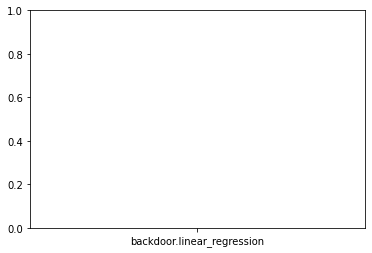

In [12]:
plot_deviations(estimator_list, deviation_list)
for i in range(len(estimator_list)):
    print(estimator_list[i] +": "+ str(deviation_list[i]))

In [13]:
{k: v for k, v in sorted(zip(estimator_list, deviation_list), key=lambda item: item[1], reverse = True)}


/home/amshar/python-environments/vpy38/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/amshar/python-environments/vpy38/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/amshar/python-environments/vpy38/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/amshar/python-environments/vpy38/lib/pyth

### Ranking based on New Effect (Refutatation results) 

The ranking based on absolute value of deviations is :
1. Propensity Score Matching 
2. Linear DR Learner 
3. DML CATE Estimator 
4. Linear Regression

Clearly, the observed unmodelled confounding error is not able to match the ranking based on the Original Estimate. It is not even able to tell that the clear winner amongst the methods according to the true value is DML CATE Estimator 

## Unobserved confounding error

For each estimator, we now simulate unobserved confounders and check its effect using dummy outcome refuter to check the unobserved confounding error for each estimator. That is, we run the refutation test for each estimator not only on the observed confounder, but also on an unobserved confounder that we simulate using the AddUnobservedCommonCause class and analyse whether there is a strong confounder that is unobserved (missing) and needs to be accounted for. 



Running Experiment: Test_2


Running Experiment Number: 0


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[99.60589522],
       [-0.1599873 ],
       [-0.47125402],
       [ 1.07750586],
       [-0.20680104],
       [-0.94475535]]), 'confounder=>outcome': array([[99.12876973],
       [ 0.12274805],
       [ 1.37571418],
       [-0.49352748],
       [-0.6239917 ],
       [ 0.87818925]]), 'effect_modifier=>outcome': array([[-1.22769743],
       [ 0.74293177]]), 'treatment=>outcome': array([[0.26451385]])}
        bias: {'confounder=>treatment': array([0.11005176]), 'confounder=>outcome': array([1.55641441])}
        seed: None
        treatment_is_binary: True
        percentile: 0.9
        
printing data shap

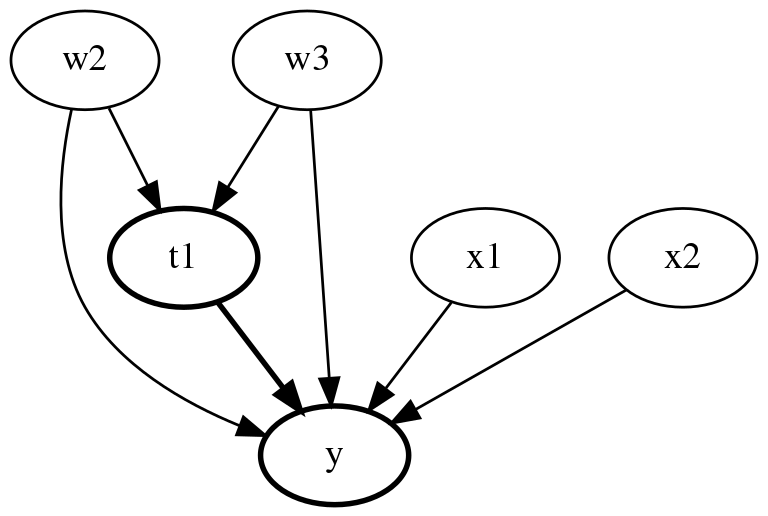

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w2,w3))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w2,w3,U) = P(y|t1,w2,w3)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['x1', 'x2']}


/home/amshar/python-environments/vpy38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


ValueError: zero-size array to reduction operation maximum which has no identity

In [14]:
unobserved_confounding_error = Experiment(
    experiment_name='Test',
    experiment_id='2',
    num_experiments=10, # 10
    sample_sizes=sample_size,
    dgps=dgp_list,
    estimators=estimator_tuples,
    refuters=refuter_tuples,
    simulate_unobserved_confounding = True
)

# Run the experiment
res = pd.read_csv(unobserved_confounding_error.experiment())

In [15]:
##This plot shows the Mean Absolute Error of the Orginal Estimate from the true value and of the New Effect from 
#the expected value for each estimator.
plot_MAEs(res)

NameError: name 'res' is not defined

### Ranking based on Original Estimate

The Original Estimate is calculated in the presence of the True Value (that is, the ground truth). However in many real life datasets, the ground truth may not be known. Hence, we want the ranking produced by our refutation tests to be in coherence with that obtained from the Original Estimates. According to the Original Estimate values, the ranking of the estimators should be as follows (the method with the least MAE should get the best rank):
1. DMLCateEstimator 
2. Propensity Score Matching 
3. LinearRegression 
4. LinearDRLearner 

In [16]:
#This plot shows the deviation of the original estimate, the new effect and the estimated effect from the true value
refuter = 'dummy_outcome_refuter'
deviation_list = []
for estimator in estimator_list:
    plot_estimators_and_refuters(refuter, estimator)
    avg_deviation = ((res[refuter+':'+estimator+':NEW_EFFECT']).sum(axis=0))
    print(avg_deviation)
    deviation_list.append(avg_deviation)

NameError: name 'res' is not defined

ValueError: x and y must be the same size

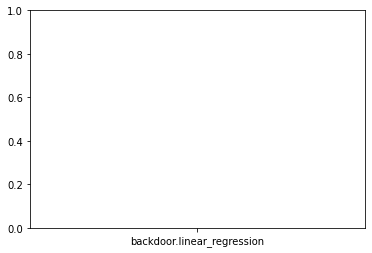

In [17]:
plot_deviations(estimator_list, deviation_list)
for i in range(len(estimator_list)):
    print(estimator_list[i] +": "+ str(deviation_list[i]))

In [18]:
{k: v for k, v in sorted(zip(estimator_list, deviation_list), key=lambda item: item[1], reverse = True)}

/home/amshar/python-environments/vpy38/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/amshar/python-environments/vpy38/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/amshar/python-environments/vpy38/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/amshar/python-environments/vpy38/lib/pyth

### Ranking based on New Effect (Refutatation results) 

The ranking based on absolute value of deviations is :
1. DML
2. Linear DR Learner 
3. Propensity Score Matching
4. Linear Regression

#### We can see that this ranking produces the same top-ranked estimator as the one based on Original Estimate. Thus ranking based on the unobserved confounding error solves the problem and gives us a close-to-correct ranking amongst methods.